In [1]:
## Data Collection 
import pandas_datareader as pdr

In [4]:
df = pdr.get_data_tiingo('AAPL',api_key='b44598a51366407c2528d359863ba91eb75ed4e6')

In [5]:
df.to_csv('AAPL.csv')

In [6]:
import pandas as pd 
df = pd.read_csv('AAPL.csv')

In [7]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-06-07 00:00:00+00:00,99.03,99.8700,98.96,99.25,22409450,23.124837,23.320988,23.108491,23.176210,89637800,0.0,1.0
1,AAPL,2016-06-08 00:00:00+00:00,98.94,99.5600,98.68,99.02,20848131,23.103821,23.248599,23.043107,23.122502,83392524,0.0,1.0
2,AAPL,2016-06-09 00:00:00+00:00,99.65,99.9900,98.46,98.50,26601354,23.269615,23.349010,22.991734,23.001075,106405416,0.0,1.0
3,AAPL,2016-06-10 00:00:00+00:00,98.83,99.3457,98.48,98.53,31712936,23.078134,23.198557,22.996404,23.008080,126851744,0.0,1.0
4,AAPL,2016-06-13 00:00:00+00:00,97.34,99.1200,97.10,98.69,38020494,22.730199,23.145853,22.674156,23.045442,152081976,0.0,1.0


In [8]:
df2 = df.reset_index()['close']

In [9]:
df2.head()

0    99.03
1    98.94
2    99.65
3    98.83
4    97.34
Name: close, dtype: float64

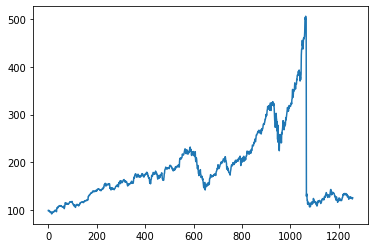

In [10]:
import matplotlib.pyplot as plt
plt.plot(df2)

In [12]:
### LSTM is sensitive to the scale of the data, hence we need to put a min max scale 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1 =scaler.fit_transform(np.array(df2).reshape(-1,1))

In [13]:
df1

array([[0.01688202],
       [0.01666465],
       [0.01837942],
       ...,
       [0.07974882],
       [0.07607777],
       [0.08175341]])

In [14]:
# splitting the dataset into train and test dataset 
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:]

In [17]:
# We will use timesteps for timeseries data. It helps modify the data in a manner that 
# it converts some values as independent and some as dependent. 
# This is basically creating a stacked LSTM model
import numpy as np
def create_dataset(dataset, time_step =1):
  dataX,dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]   ### i =0, 0,1,2,3
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [18]:
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [19]:
# We need to reshape the data for LSTM to be three dimensional
# ['samples','time_steps','features']
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [21]:
# Importing important libraries 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = (100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
12/12 [==============================] - 7s 259ms/step - loss: 0.0100 - val_loss: 0.0471
Epoch 2/100
12/12 [==============================] - 2s 169ms/step - loss: 0.0025 - val_loss: 0.0264
Epoch 3/100
12/12 [==============================] - 2s 169ms/step - loss: 0.0011 - val_loss: 0.0224
Epoch 4/100
12/12 [==============================] - 2s 168ms/step - loss: 6.1494e-04 - val_loss: 0.0209
Epoch 5/100
12/12 [==============================] - 2s 169ms/step - loss: 4.4563e-04 - val_loss: 0.0217
Epoch 6/100
12/12 [==============================] - 2s 170ms/step - loss: 4.4416e-04 - val_loss: 0.0208
Epoch 7/100
12/12 [==============================] - 2s 170ms/step - loss: 4.3124e-04 - val_loss: 0.0197
Epoch 8/100
12/12 [==============================] - 2s 173ms/step - loss: 4.0818e-04 - val_loss: 0.0194
Epoch 9/100
12/12 [==============================] - 2s 169ms/step - loss: 3.9174e-04 - val_loss: 0.0189
Epoch 10/100
12/12 [==============================] - 2s 169ms/step

In [27]:
import tensorflow as tf
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [28]:
import math 
from sklearn.metrics import mean_squared_error

In [30]:
math.sqrt(mean_squared_error(y_train,train_predict))
math.sqrt(mean_squared_error(y_test,test_predict))

226.48546071833243

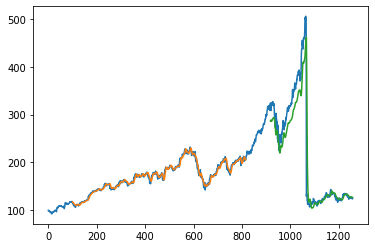

In [33]:
#Plotting
# shift train predictions for plotting 
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

#shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+look_back*2+1:len(df1)-1,:] = test_predict

#Plotting 
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()


# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    


[0.08154128]
101
1 day input [0.09382925 0.08904722 0.08477237 0.08643884 0.09658254 0.10827195
 0.11358532 0.12288371 0.12346335 0.12080667 0.10880328 0.09641348
 0.10167854 0.10373143 0.10119551 0.10952783 0.10800628 0.10836855
 0.1061949  0.1046975  0.10406956 0.1046492  0.09938413 0.09370849
 0.09097935 0.09136578 0.08201908 0.08168096 0.08044922 0.06991909
 0.07057119 0.08634223 0.07989373 0.07250332 0.06784205 0.07095761
 0.05873687 0.07014853 0.06747977 0.0722618  0.0700157  0.07716459
 0.08098056 0.07902427 0.06880811 0.06750392 0.07571549 0.0736626
 0.06774544 0.06895302 0.07045043 0.07088516 0.06728656 0.07272069
 0.07477358 0.08177756 0.08252626 0.0866079  0.09254921 0.09891317
 0.09467456 0.10237894 0.09658254 0.102548   0.10172684 0.10336916
 0.09919092 0.10013283 0.09636517 0.10211327 0.10307934 0.10228233
 0.10032605 0.10008453 0.09520589 0.09781427 0.08648714 0.08709093
 0.09105181 0.09218693 0.08407197 0.08180171 0.07421809 0.07953146
 0.08552107 0.08267117 0.07924164 

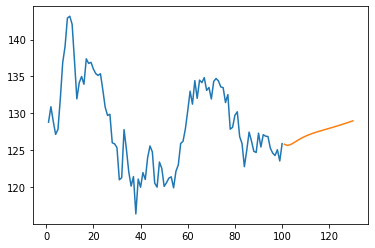

In [35]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

import matplotlib.pyplot as plt

plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))



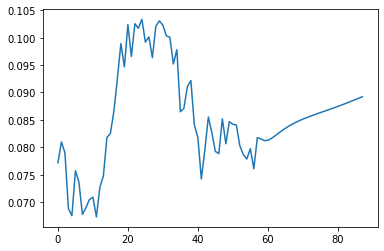

In [36]:

df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [37]:

df3=scaler.inverse_transform(df3).tolist()

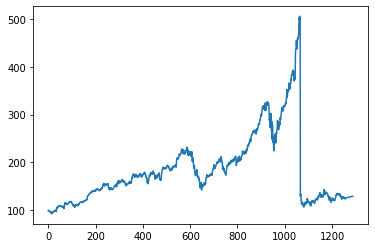

In [38]:
plt.plot(df3)